# Project 4: Advanced Lane Finding

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Camera Calibration

In [2]:
# prepare object points

def get_points(image_files, nx=9, ny=6):
    objpoints = []
    imgpoints = []

    # Make a list of calibration images
    print("this is image_files: ", image_files)
    
    for image_file in image_files:
        img = cv2.imread(image_file)
        
        # construct object point, this is the same for every 9x6 chessboard
        objpoint = np.zeros((ny*nx,3), np.float32)
        
        # x, y coordinates, leave z coordinate as 0 since it's always 0 on a flat plane
        objpoint[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) 

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret:
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imshow(img)
            objpoints.append(objpoint)
            imgpoints.append(corners)
        else:
            print("ret is false!!")
            # some images have dimensions other than nx=9 and ny=6
    return objpoints, imgpoints


this is image_files:  ['camera_cal/calibration1.jpg', 'camera_cal/calibration10.jpg', 'camera_cal/calibration11.jpg', 'camera_cal/calibration12.jpg', 'camera_cal/calibration13.jpg', 'camera_cal/calibration14.jpg', 'camera_cal/calibration15.jpg', 'camera_cal/calibration16.jpg', 'camera_cal/calibration17.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration19.jpg', 'camera_cal/calibration2.jpg', 'camera_cal/calibration20.jpg', 'camera_cal/calibration3.jpg', 'camera_cal/calibration4.jpg', 'camera_cal/calibration5.jpg', 'camera_cal/calibration6.jpg', 'camera_cal/calibration7.jpg', 'camera_cal/calibration8.jpg', 'camera_cal/calibration9.jpg']
ret is false!!
ret is false!!
ret is false!!


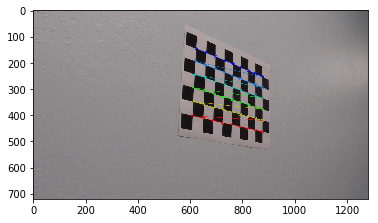

In [3]:
import glob

# feed calibration image files to get objpoints and imgpoints
image_files = glob.glob('camera_cal/calibration*.jpg') # I could also use import os
objpoints, imgpoints = get_points(image_files)

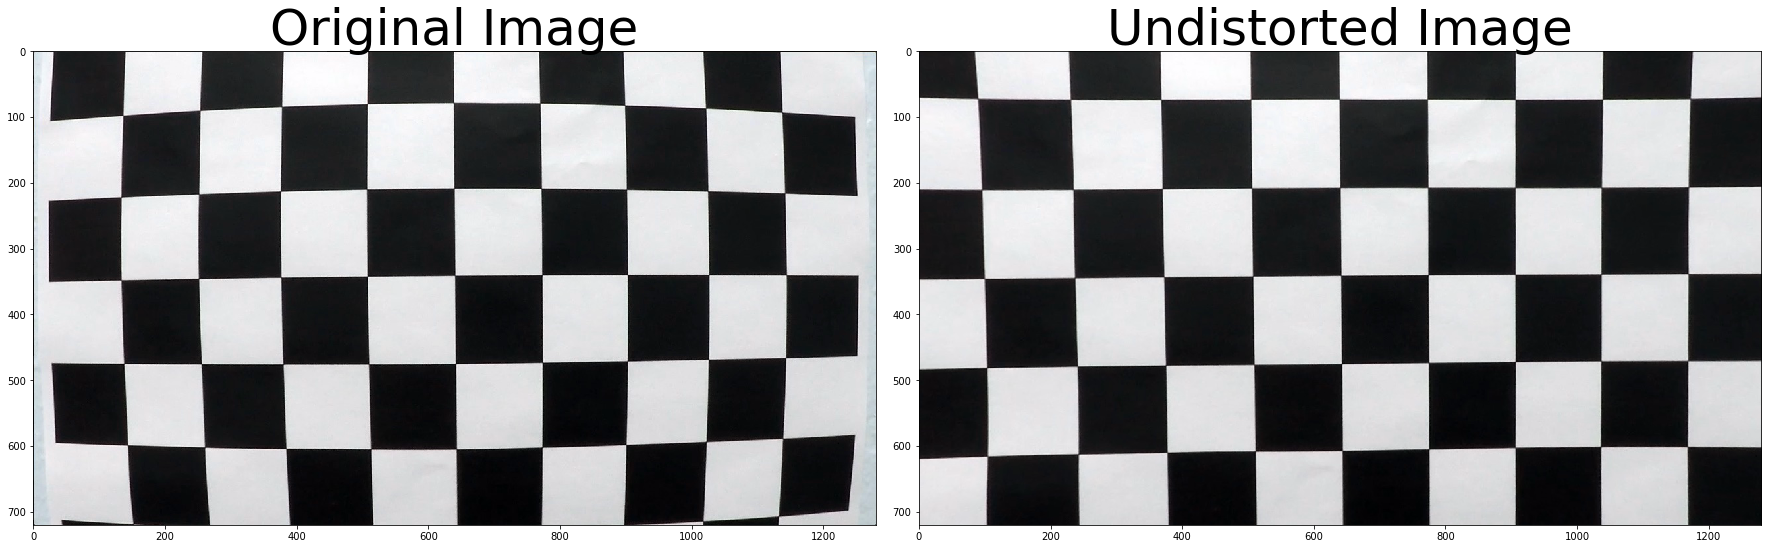

In [4]:
# calibrate camera

#use calibration1.jpg as test_image since it has odd dimension (nx=9, ny=5)
test_image = cv2.imread('camera_cal/calibration1.jpg')

# only need to call cv2.calibrateCamera once, save the output variables so they can be reused
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test_image.shape[0:2], None, None)
undist = cv2.undistort(test_image, cameraMatrix, distCoeffs, None, cameraMatrix)


# undistorted_image, mtx = cal_undistort(test_image, objpoints, imgpoints)

# debugger
# import pdb; pdb.set_trace()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig('output_images/undistort_output.png', dpi=100)

## Image Transform to Binary

### X/Y Gradient Transform

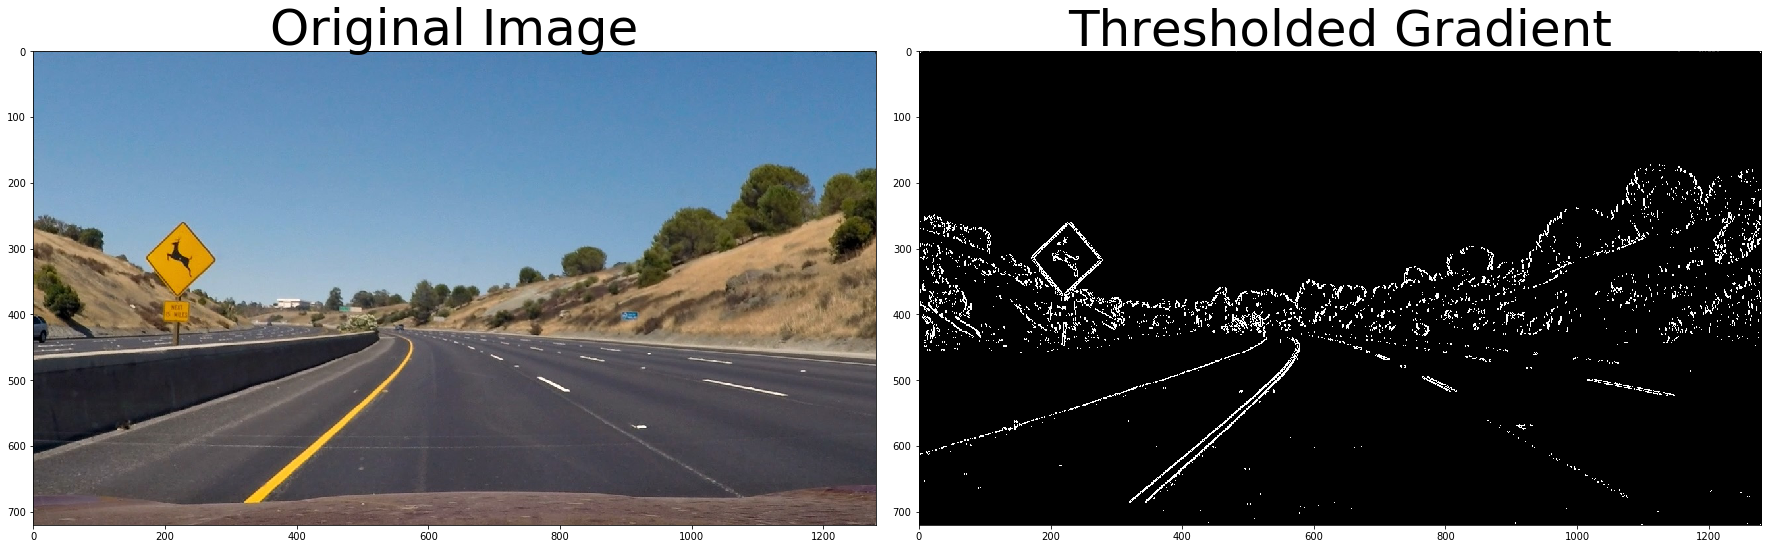

In [5]:
# Gradients
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Apply the following steps to img
    # 1) Convert to grayscale, since cv2.Sobel only takes one value in color channel
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'y':
        deriv = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        deriv = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_deriv = np.absolute(deriv)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # scale to 8-bit is just to standardize the pixels in the input image
    scaled_deriv = np.uint8(255*abs_deriv/np.max(abs_deriv))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_deriv)
    binary_output[(scaled_deriv > thresh[0]) & (scaled_deriv < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

image1 = cv2.imread('test_images/test2.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

grad_binary = abs_sobel_thresh(image1, orient='x', sobel_kernel=3, thresh=(30,120))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Gradient Magnitude Transform

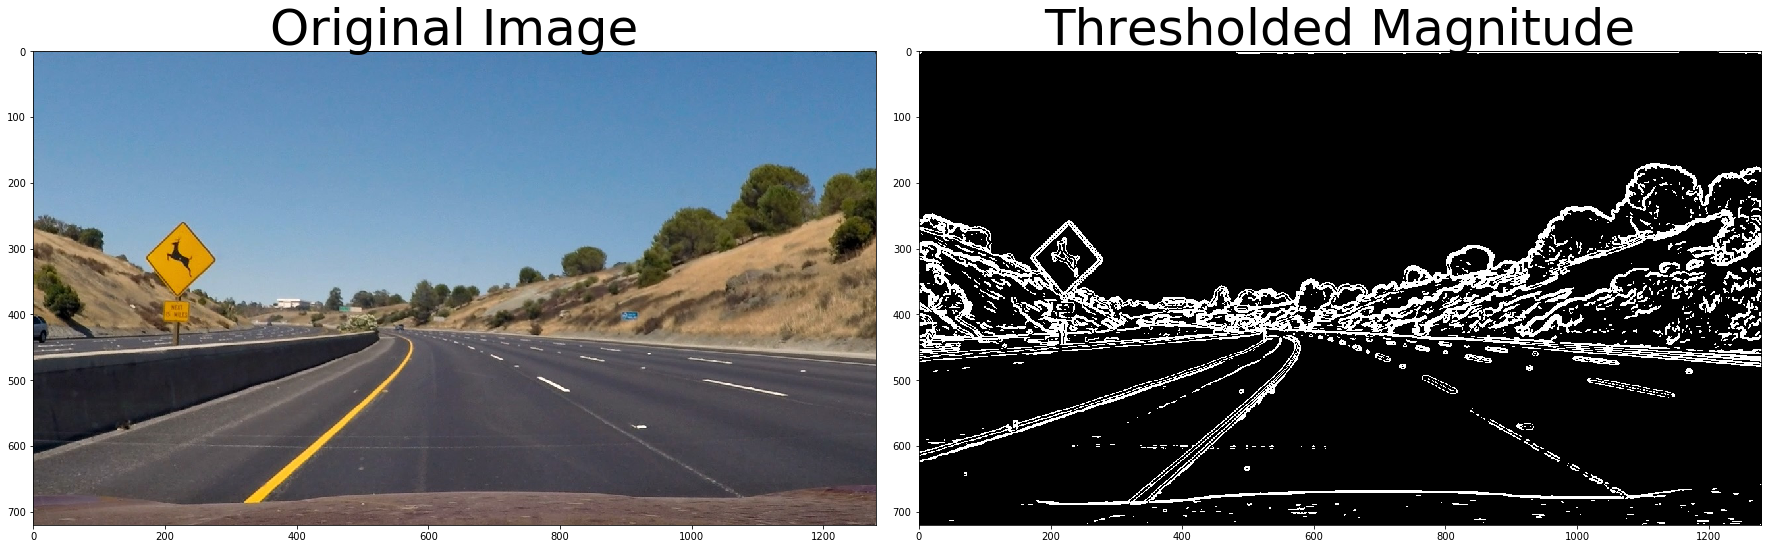

In [6]:
# Magnitude of gradients (i.e. accounting gradients w.r.t both x and y)

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_mag = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_mag) #creates a np.array of shape like scaled_mag but all zeros
    binary_output[(scaled_mag > mag_thresh[0]) & (scaled_mag < mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# Run the function
# use the same test image, image1 loaded in the previous cell
mag_binary = mag_thresh(image1, sobel_kernel=11, mag_thresh=(30, 120))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



### Direction of the Gradient Transform

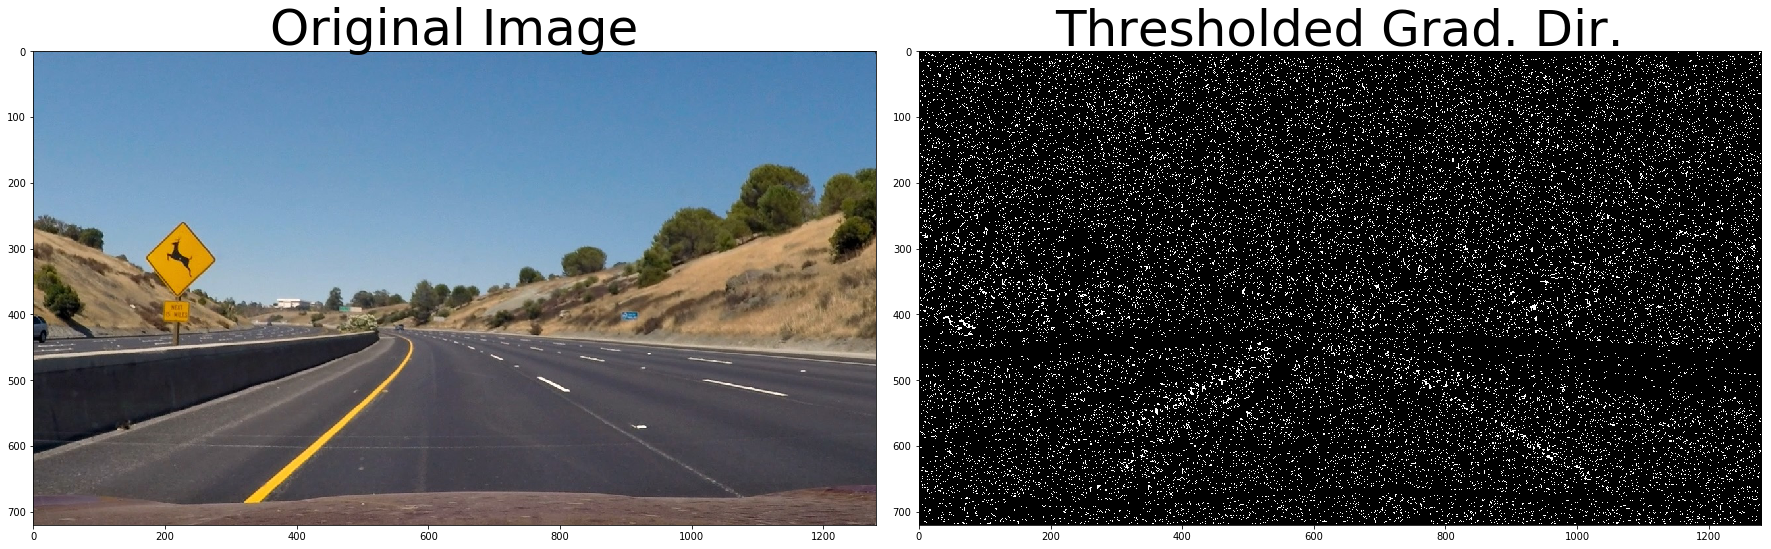

In [7]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction > thresh[0]) & (direction < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output


# Run the function
dir_binary = dir_threshold(image1, sobel_kernel=15, thresh=(0.95, 1.05)) # 0=horiz line, +-pi/2=vert line
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Combining the three Gradient transformations

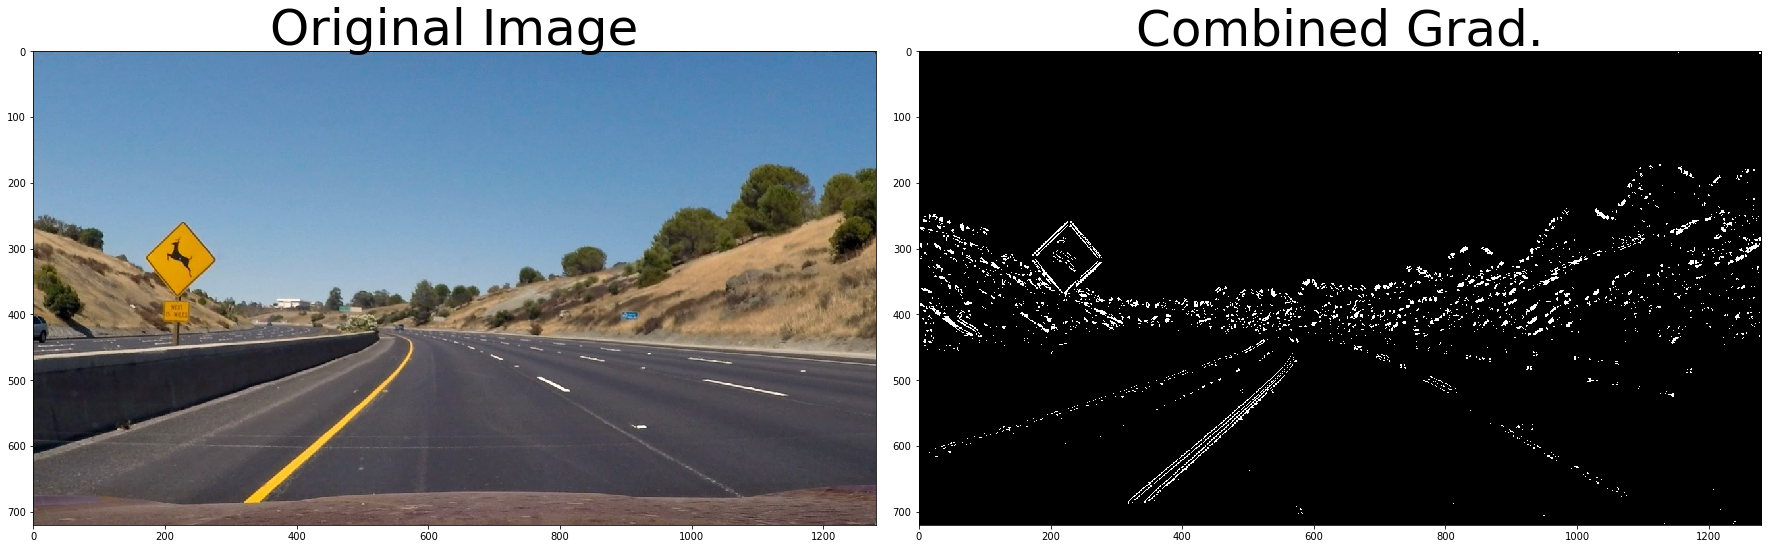

In [8]:
ksize = 15
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image1, orient='x', sobel_kernel=ksize, thresh=(40, 110))
grady = abs_sobel_thresh(image1, orient='y', sobel_kernel=ksize, thresh=(40, 110))
mag_binary = mag_thresh(image1, sobel_kernel=ksize, mag_thresh=(30, 120))
dir_binary = dir_threshold(image1, sobel_kernel=ksize, thresh=(0.95, 1.05))

# initialized the combined np array
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Grad.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Color Transform

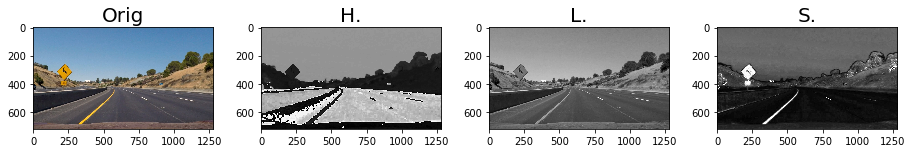

In [9]:
# Represent the test image in HLS color space

hls = cv2.cvtColor(image1, cv2.COLOR_RGB2HLS)

H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

# Plot the result
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 5))
f.tight_layout()
ax1.imshow(image1)
ax1.set_title('Orig', fontsize=20)
ax2.imshow(H, cmap='gray')
ax2.set_title('H.', fontsize=20)
ax3.imshow(L, cmap='gray')
ax3.set_title('L.', fontsize=20)
ax4.imshow(S, cmap='gray')
ax4.set_title('S.', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### HLS Threshold Using the S Channel

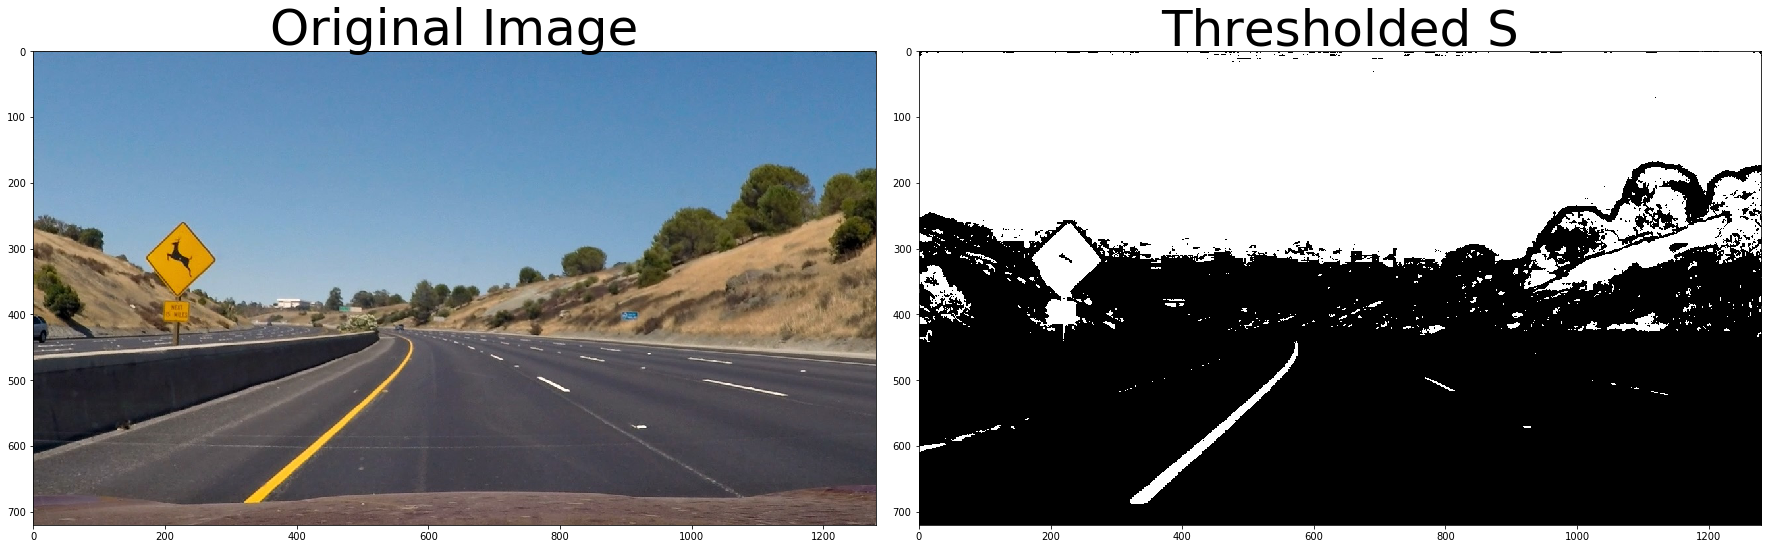

In [10]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(s > thresh[0]) & (s <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

hls_binary = hls_select(image1, thresh=(90, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Gradients and Color Transform

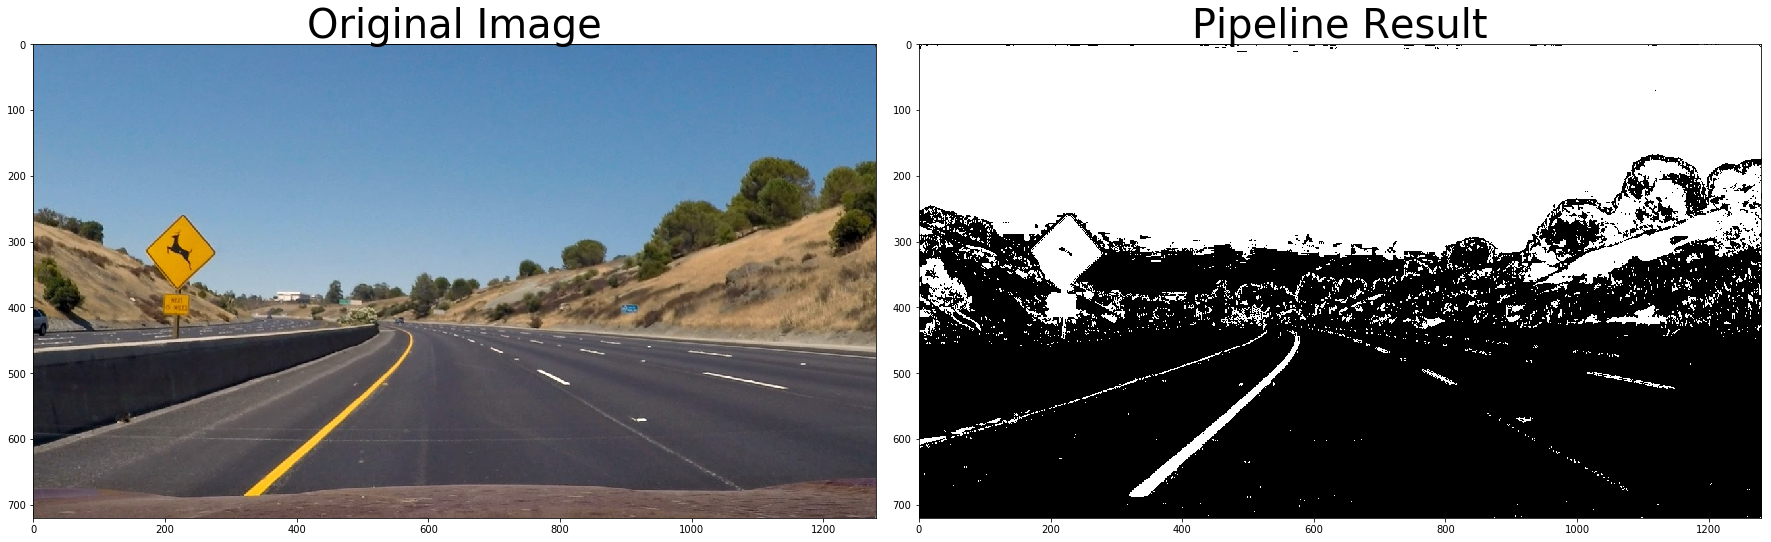

In [11]:
# Edit this function to create your own pipeline.
def transform_pipeline(img, s_thresh=(90, 255), sx_thresh=(30, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    #return color_binary
    
    binary = np.zeros_like(s_binary)
    binary[((sxbinary == 1) | (s_binary == 1))] = 255
    return binary
    
result = transform_pipeline(image1)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image1)
ax1.set_title('Original Image', fontsize=40)

# ax2.imshow(result) # use this if showing a color_binary from the transform_pipeline method
ax2.imshow(result, cmap='gray') # use this if showing a BW binary from the transform_pipeline method
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Try to combine the R channel (good for white lines) and the S channel (good for yellow lines)!!!!!!!!!!!!

## Perspective Transform & Lane Finding
Now we can perform a perspective transformation on an image, original or binary, so that we can easily plot a polynomial line to fit the lane line and then unwarp the image back to its initial form with the lane lines added.

### Perspective Transform
Define a method, `warper()` so that for a given image, `img`, it returns a warped image and a perspective transform matrix, `M`.

In [12]:
def warper(img, camera_matrix, distortion_coefficients, source, destination):
    # undistort img first
    undist = cv2.undistort(img, camera_matrix, distortion_coefficients, None, camera_matrix)
    
    # need to convert to grayscale since warpPerspective only takes in one value in the color channel
    # NO NEED TO DO THIS IF THE IMAGE IS A BINARY IMAGE
    #gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    
    M = cv2.getPerspectiveTransform(source,destination)
    Minv = cv2.getPerspectiveTransform(destination,source)
    
#     print("this is img: ", img)
#     print("this is undist: ", undist)
    
    #print("this is gray.shape[::-1]: ", gray.shape[::-1])
    #print("this is gray.shape: ", gray.shape)
    #print("this is img.shape: ", img.shape)
    
    warped = cv2.warpPerspective(undist, M, img.shape[::-1], flags=cv2.INTER_LINEAR)
    
#     print("this is warped!!!!!!! ", warped)
    
    return warped, M, Minv

Now using the `warper()` method, we can visualize what a binary image looks like after it's perspective transformation:

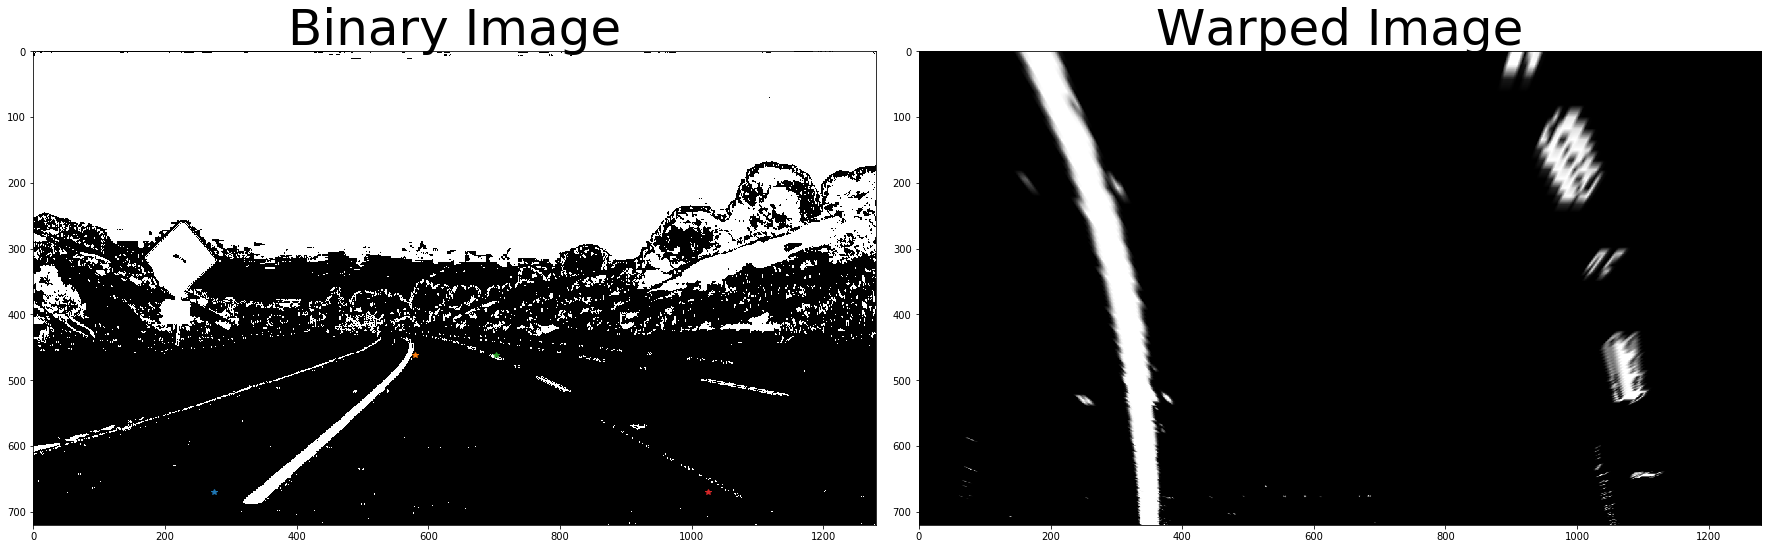

In [13]:
# got src from Mac preview
# https://apple.stackexchange.com/questions/65162/retrieve-image-coordinates-at-mouse-cursor-in-preview-app
src = np.float32([[275,669],[580,461],[703,461],[1025,669]])
dst = np.float32([[275,720],[280,100],[1020,100],[1025,720]])

warped_result, M, Minv = warper(result, cameraMatrix, distCoeffs, src, dst)

# Draw source and destination point "rectangles"
# cv2.polylines(result,[src.reshape((-1,1,2)).astype(np.int32)],True,(255,0,0), thickness=4)
# cv2.polylines(warped_result,[dst.reshape((-1,1,2)).astype(np.int32)],True,(255,0,0), thickness=8)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(result, cmap='gray')
ax1.plot(275,669,'*')
ax1.plot(580,461,'*')
ax1.plot(703,461,'*')
ax1.plot(1025,669,'*')
ax1.set_title('Binary Image', fontsize=50)
ax2.imshow(warped_result, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Lane Finding Method: Peaks in a Histogram
Having performed a perspective transformation on an image, we now need to find lane lines in the transformed image. We will do that by finding peaks in a histogram.

This is useful because since we had already performed color and gradient transformations, what's left should be pixels related to the lane lines. If we sum up all these pixels and show these summations as a histogram, we can see peaks in the histogram that correspond to the lane lines:

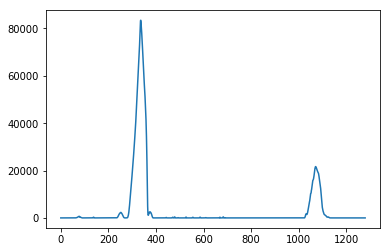

In [14]:
histogram = np.sum(warped_result[warped_result.shape[0]//2:,:], axis=0)
plt.plot(histogram)

The goal of this exercise is to dynamically identify all nonzero pixels (their x,y positions) that make up the left lane line, and all nonzero pixels that make up the right lane line, so that we can pass these points to the `numpy.polyfit()` method to generate polynomial lines that fit each of the lane lines separately.

With this in mind, we can define a **sliding window** algorithm that dynamically finds all the pixels for the left and right lane lines in a warped image. Take the left window for example, it starts at the bottom of the image, and finds find all the pixels (that make up part of the left lane line) within itself and add it to a list of all left lane pixels. The left window will then slide and re-center itself based on the mean x position of all the pixels in the previous left window. In the end, we have all but captured all the pixels that belong to the left lane line. The same will be done for the right lane line.

The `fit_sliding_window` algorithm will return two numpy arrays of image pixels, one for the left lane line and one for the right lane line.

In [15]:
def fit_sliding_window(image, nwindows=9):
    # Assuming you have created a warped binary image called "image"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[int(image.shape[0]/2):,:], axis=0)
    # print("this is image.shape[0]: ", int(image.shape[0] / 2))
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack([image]*3)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,1,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,1,0), 3)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    print("this is leftx: ", leftx.shape)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

    return leftx, lefty, rightx, righty, out_img
    
#     # Fit a second order polynomial to each
#     left_fit = np.polyfit(lefty, leftx, 2)
#     right_fit = np.polyfit(righty, rightx, 2)
    
#     return left_fit, right_fit, out_img


Now to visualize the sliding windows that were used to to get the respective pixels and the ultimate polynomial lines, you can see the lines do a good job of approximating the lane lines:

this is leftx:  (42635,)


(720, 0)

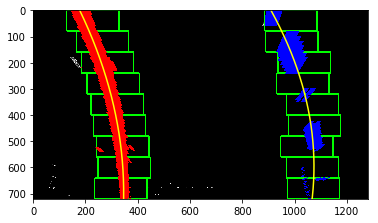

In [16]:
leftx, lefty, rightx, righty, out_img = fit_sliding_window(warped_result)

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped_result.shape[0]-1, warped_result.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Sliding Window: More Robust Approach
Using the x mean centering approach above seems to work well, but a more robust approach would be using a convolution, which helps us find where the most overlapping pixel positions are, and those in turn represent the actual positions of the lane lines.

this is l_point:  (720, 1280)


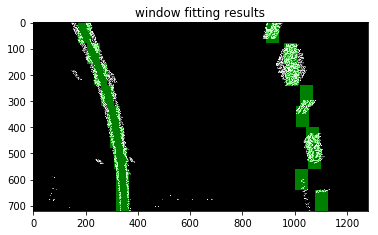

In [17]:

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


# def fit_sliding_windows_conv(image, window_centroids):
#     # If we found any window centers
#     if len(window_centroids) > 0:
#         # Points used to draw all the left and right windows
#         l_points = np.zeros_like(warped_result)
#         r_points = np.zeros_like(warped_result)

#         # Go through each level and draw the windows
#         for level in range(0,len(window_centroids)):
#             # Window_mask is a function to draw window areas
#             l_mask = window_mask(window_width,window_height,warped_result,window_centroids[level][0],level)
#             r_mask = window_mask(window_width,window_height,warped_result,window_centroids[level][1],level)
#             # Add graphic points from window mask here to total pixels found 
#             l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
#             r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
            
            
        

#         # Draw the results
#         template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
#         zero_channel = np.zeros_like(template) # create a zero color channel
#         template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
#         warpage = np.array(cv2.merge((warped_result*255,warped_result*255,warped_result*255)),np.uint8) # making the original road pixels 3 color channels
#         output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

#     # If no window centers found, just display orginal road image
#     else:
#         output = np.array(cv2.merge((warped_result,warped_result,warped_result)),np.uint8)
    



window_centroids = find_window_centroids(warped_result, window_width, window_height, margin)





# If we found any window centers
if len(window_centroids) > 0:
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped_result)
    r_points = np.zeros_like(warped_result)

    # Go through each level and draw the windows
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped_result,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped_result,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped_result*255,warped_result*255,warped_result*255)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped_result,warped_result,warped_result)),np.uint8)

  
print("this is l_point: ", l_points.shape)

    # Generate x and y values for plotting
# left_fit = np.polyfit(lefty, leftx, 2)
# right_fit = np.polyfit(lefty, leftx, 2)

# ploty = np.linspace(0, warped_result.shape[0]-1, warped_result.shape[0] )
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


### Lane Line Finding in subsequent image frames
Having identified the left and right lane lines using the polynomial lines for one image frame, we no longer have to use the **sliding window** technique to draw polynomial lane lines for the subsequent image frames, because it's safe to assume that the lane lines are in similar positions frame to frame, we can simply use the previous image's lane lines, add a margin around these lane lines and search for lane lines in the new image within this margin.

In [18]:
def find_lane_lines(image, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "image")
    # It's now much easier to find line pixels!
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped_result, warped_result, warped_result))*255
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
    
    return leftx, lefty, rightx, righty, out_img
    
#     # Fit a second order polynomial to each
#     left_fit = np.polyfit(lefty, leftx, 2)
#     right_fit = np.polyfit(righty, rightx, 2)
    
#     # Create an image to draw on and an image to show the selection window
#     out_img = np.dstack((warped_result, warped_result, warped_result))*255
    
#     # Color in left and right line pixels
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

    
#     return left_fit, right_fit, out_img

Now we use the previous image to visualize the result, but in practice, this technique would be applied to an image frame that immediately succeeds the previous image in a series of images (i.e. video):

(720, 0)

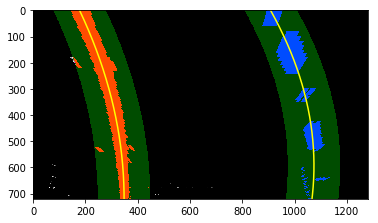

In [19]:
margin = 100

new_leftx, new_lefty, new_rightx, new_righty, out_img = find_lane_lines(warped_result, left_fit, right_fit)

# Fit a second order polynomial to each
left_fit = np.polyfit(new_lefty, new_leftx, 2)
right_fit = np.polyfit(new_righty, new_rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped_result.shape[0]-1, warped_result.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

window_img = np.zeros_like(out_img)

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,1, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,1, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Measuring Curvature
Now that we have a polynomial line that represents the lane lines, it's useful to calculate the curvature of the polynomial lines, so that in a later exercise, we can, for example, automatically feed steering angle inputs to the model.

In [20]:
def lane_curvature(image, leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(leftx)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

Now to calculate the lane curvature for the example we've been using above:

In [21]:
leftx, lefty, rightx, righty, out_img = find_lane_lines(warped_result, left_fit, right_fit)

left_curverad, right_curverad = lane_curvature(warped_result, leftx, lefty, rightx, righty)

print("left_curverad: ", left_curverad)
print("right_curverad: ", right_curverad)

left_curverad:  503.623245637
right_curverad:  349.636581851


In [22]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

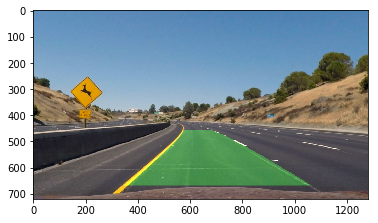

In [25]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped_result).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Generate x and y values for plotting
ploty = np.linspace(0, warped_result.shape[0]-1, warped_result.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

image1 = cv2.imread('test_images/test2.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

undist = cv2.undistort(image1, cameraMatrix, distCoeffs, None, cameraMatrix)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image1.shape[1], image1.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

## Pipeline

Now that we have all the pieces, let's put them together to form the pipeline for marking lane lines.

In [ ]:
# def pipeline(image, cameraMatrix, distCoeffs):
#     # 1) undistort image based on camera matrix and distortion coefficients
#     undist = cv2.undistort(image, cameraMatrix, distCoeffs, None, cameraMatrix)
    
#     # 2) transform undistort to binary using the specified binary_method
#     if binary_method == 'color_gradient':
#         binary_image = transform_pipeline(undist)
#     else:
#         return
    
#     # 3) perform perspective transformation to warp binary_image
#     warped_result, M = warper(result, cameraMatrix, distCoeffs, src, dst)
    
#     # 4) 
    
    
    